<a href="https://colab.research.google.com/github/jersonvc/Data-Processing/blob/main/ProcesamientoSinNucleo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import codecs

In [ ]:
###ACTUALIZAR EL TXT CON LOS NOMBRES DE LAS PROBETAS###
RutaDeEntrada = "/content/drive/MyDrive/Colab Notebooks/DatosSinNucleoPosProcesado/"
RutaDeSalida = "/content/drive/MyDrive/Colab Notebooks/GraficaCabezal/"
RutaDeLectura = "/content/drive/MyDrive/Colab Notebooks/ListaBaseDeDataSinNucleoPosProcesado.txt"
documento = codecs.open(RutaDeLectura, "r", "utf-8")
files = documento.readlines()

filenames = []
for i in range(len(files)):
  file = files[i]
  file = file[:9]
  filenames.insert(i,file)

fnames = []
for j in range(len(files)):
  f = files[j]
  f = f[:5]
  fnames.insert(j,f)

documento.close()

In [ ]:
###RAÍCES DEL POLINOMIO DE GRADO 5###
def PolGra5(c0, c1, c2, c3, c4, c5, xi, tol, y):
  xki = xi
  while True:
    xk = xki
    p_xk = c5*xk**5+c4*xk**4+c3*xk**3+c2*xk**2+c1*xk+c0-y
    pp_xk = 5*c5*xk**4+4*c4*xk**3+3*c3*xk**2+2*c2*xk+c1
    xki = xk-(p_xk/pp_xk)
    if abs(xki-xk)<tol:
        break
  return xki

In [ ]:
datos = pd.DataFrame(index=np.arange(0, len(filenames), 1), columns=['filenames', 'uc', 'un', 'm4060', 'r', 'x40', 'x60'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

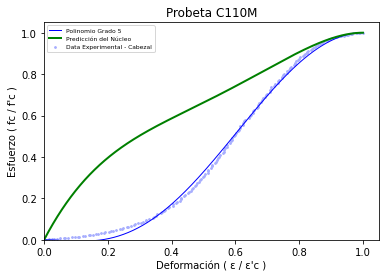

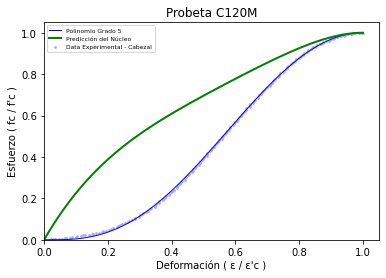

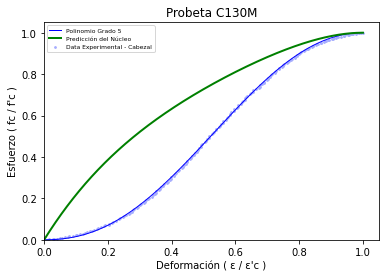

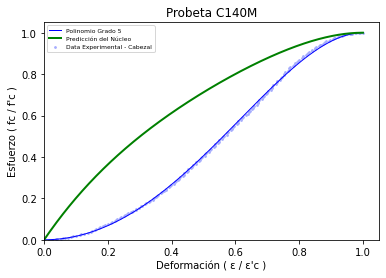

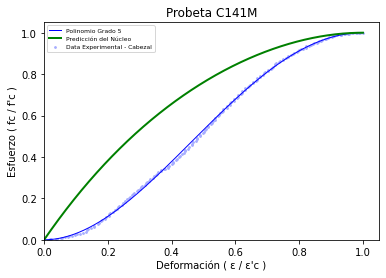

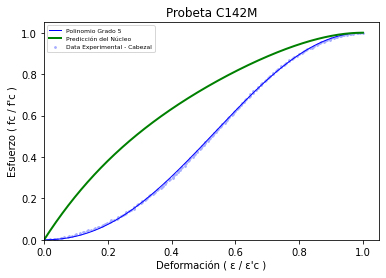

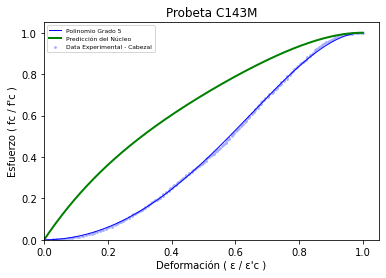

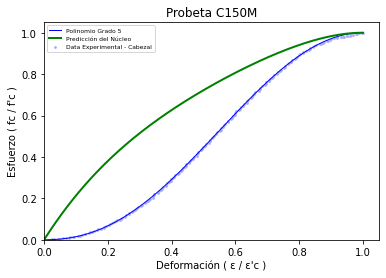

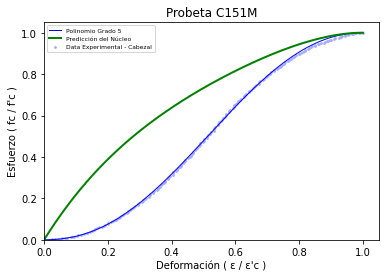

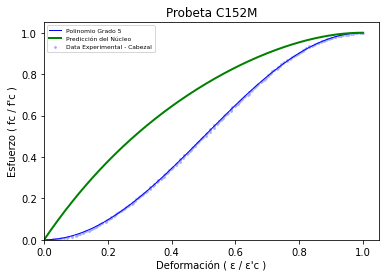

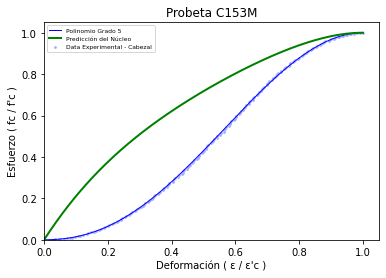

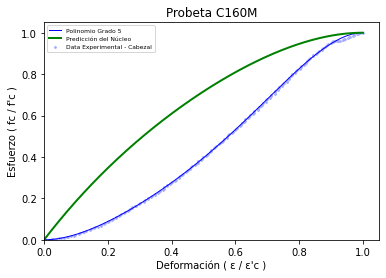

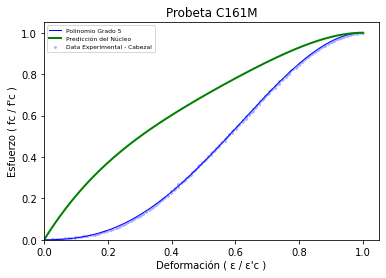

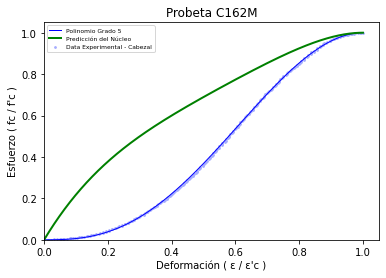

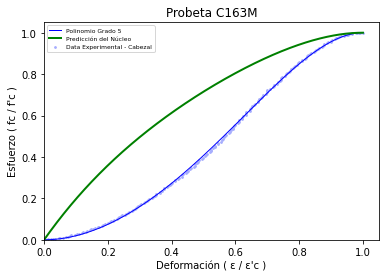

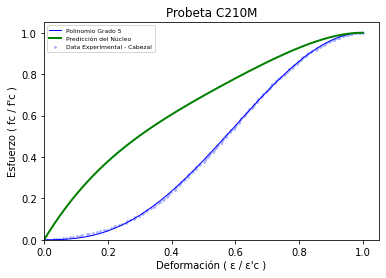

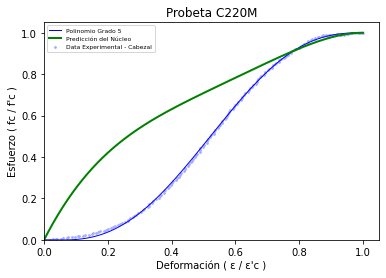

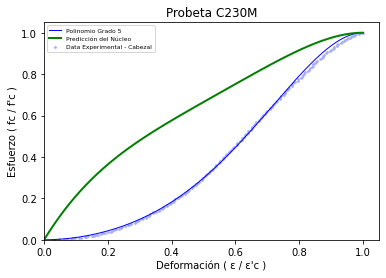

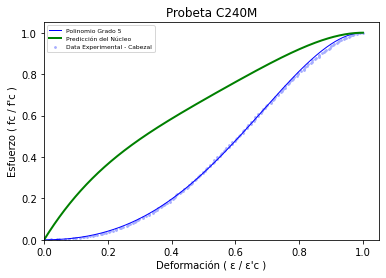

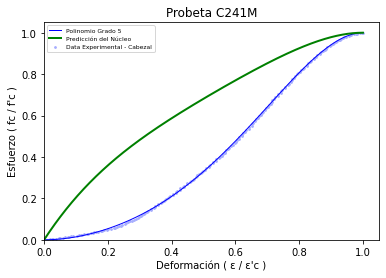

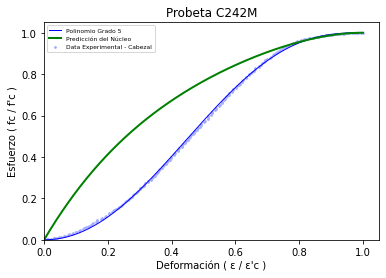

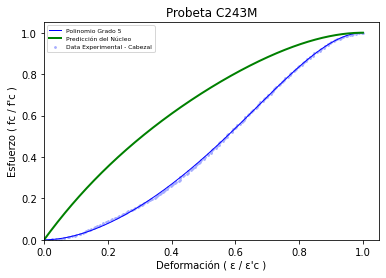

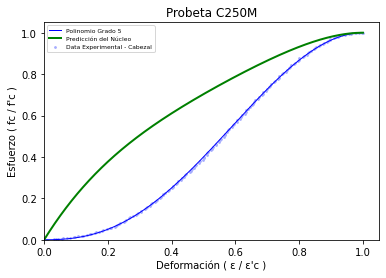

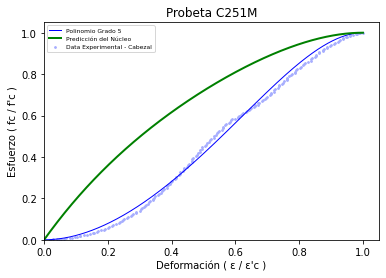

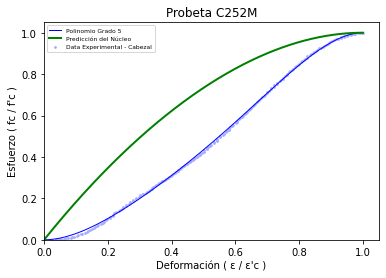

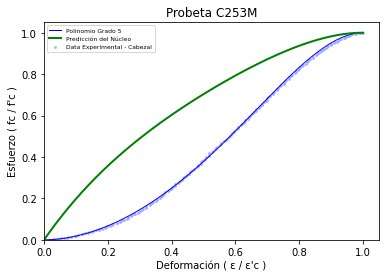

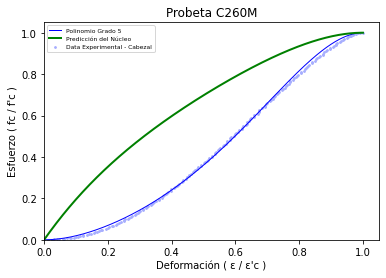

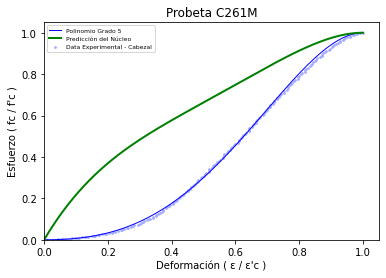

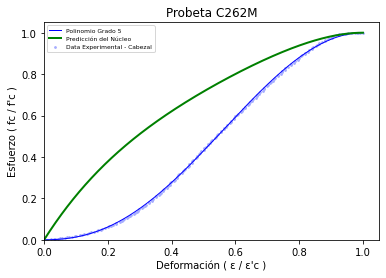

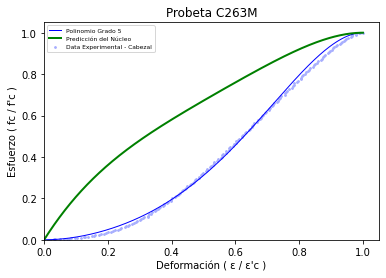

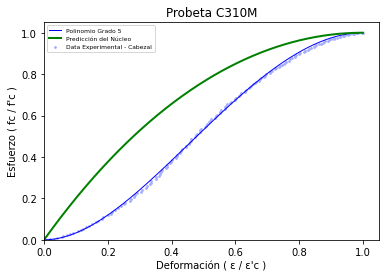

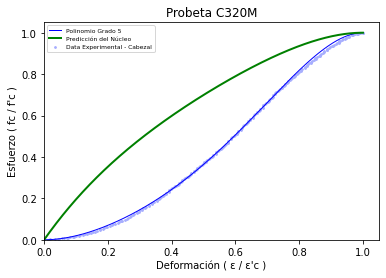

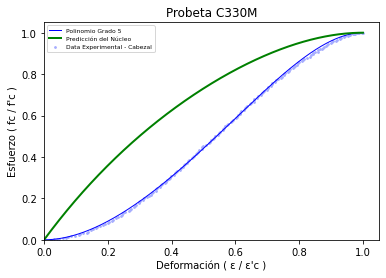

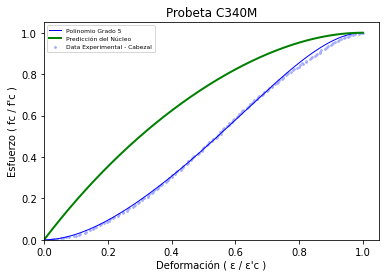

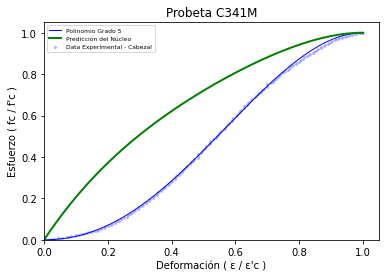

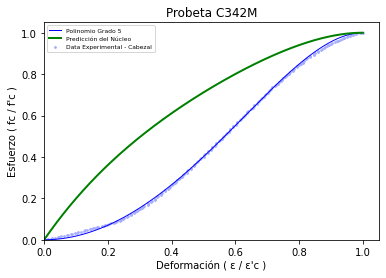

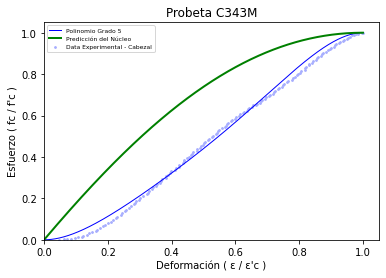

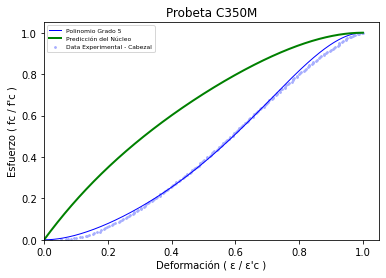

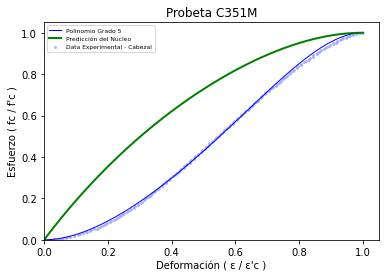

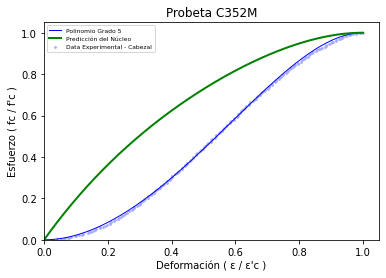

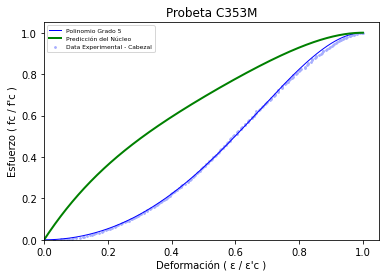

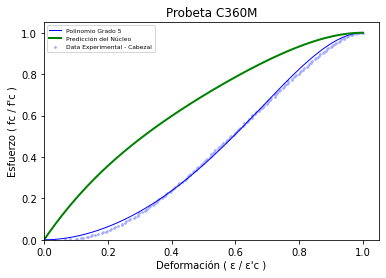

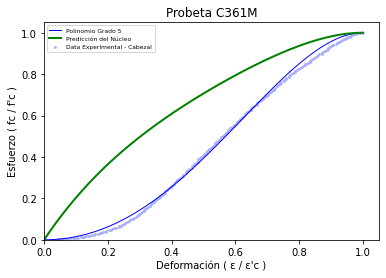

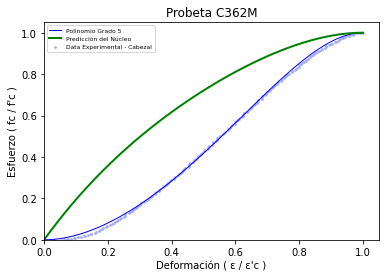

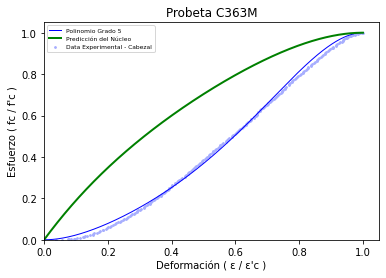

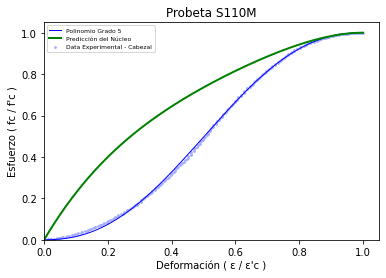

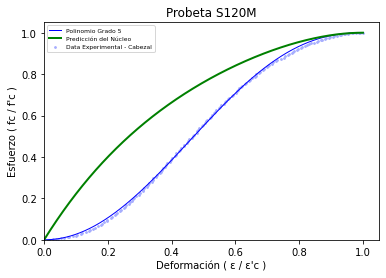

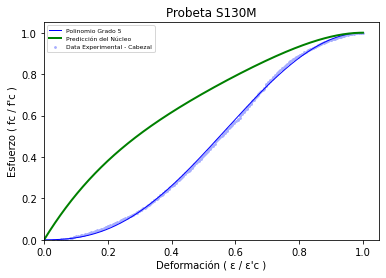

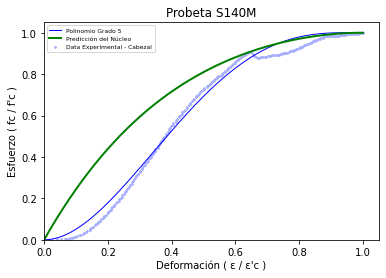

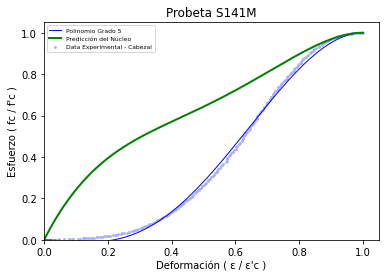

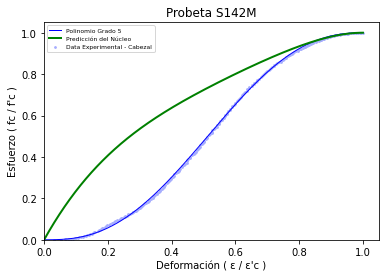

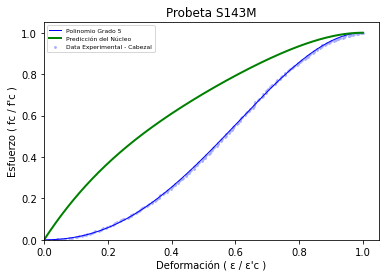

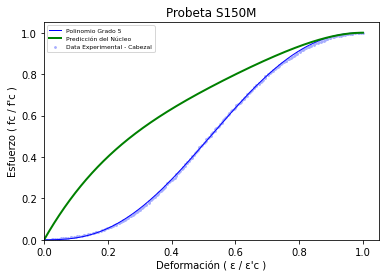

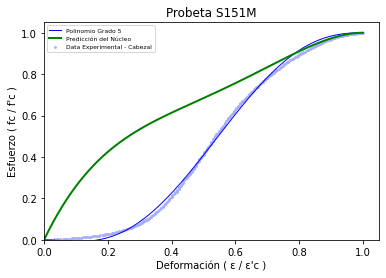

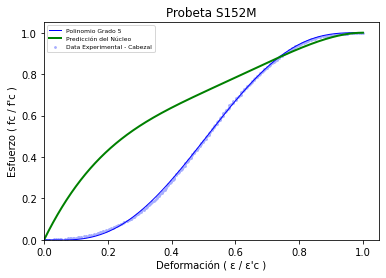

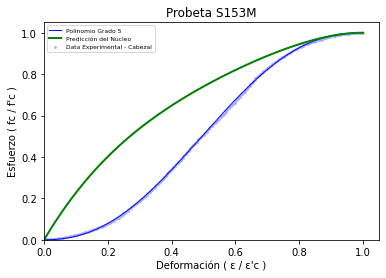

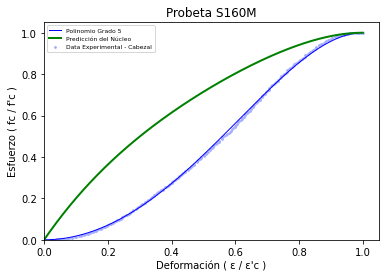

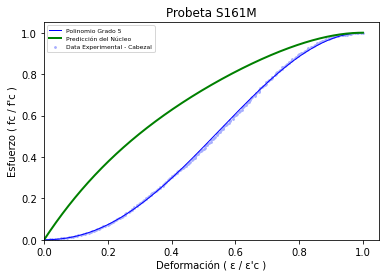

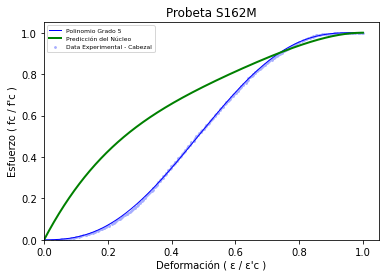

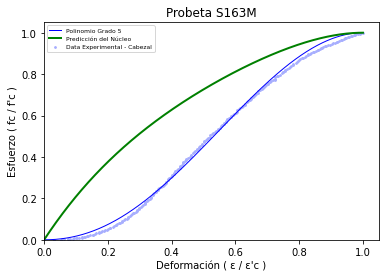

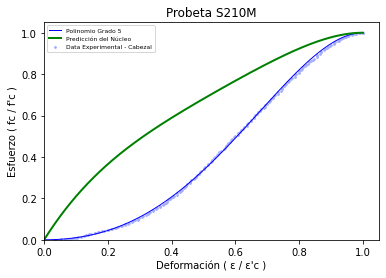

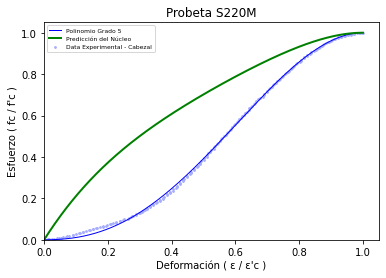

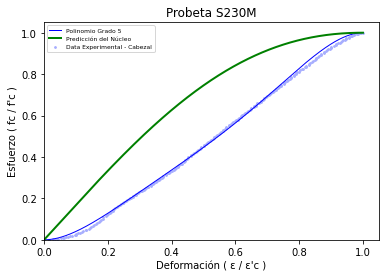

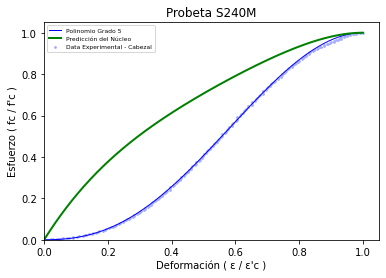

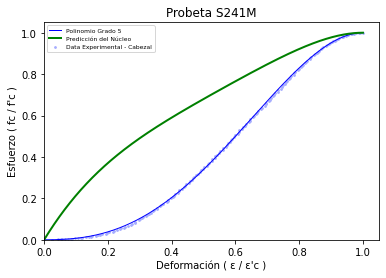

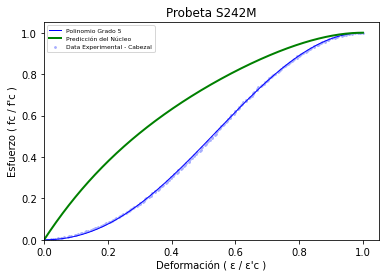

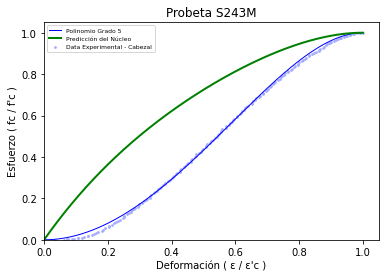

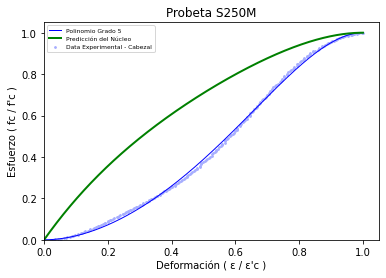

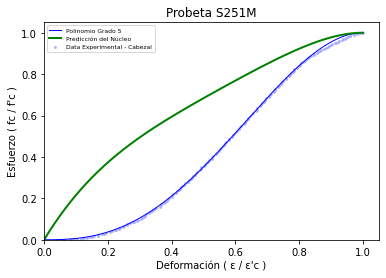

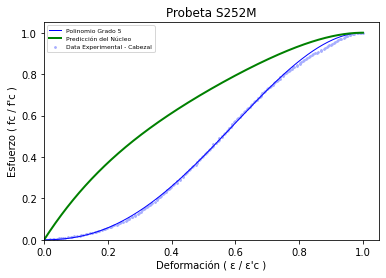

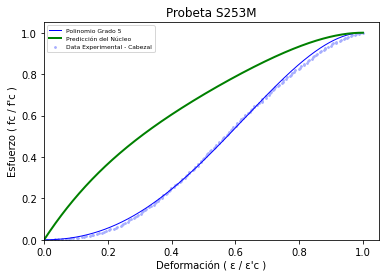

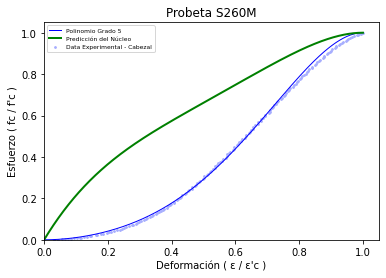

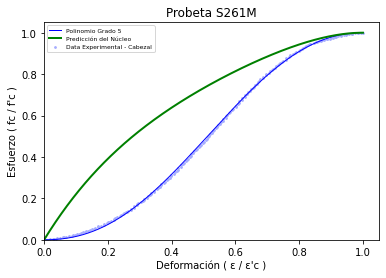

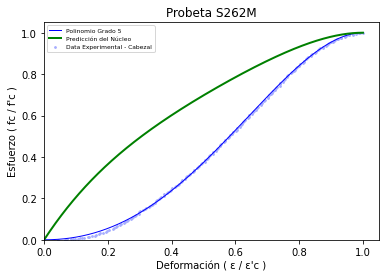

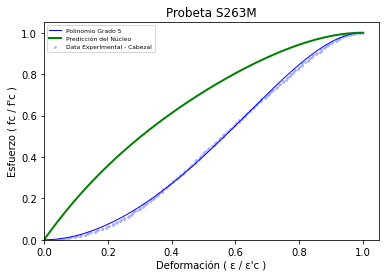

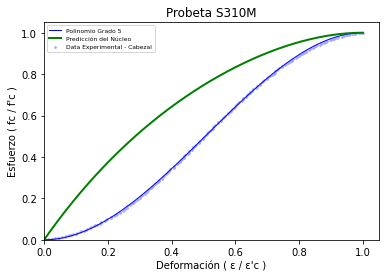

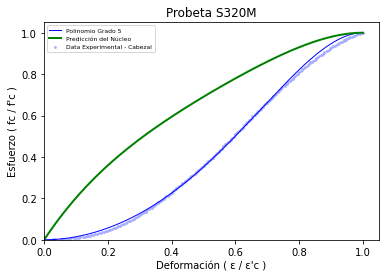

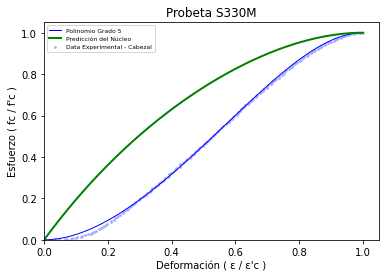

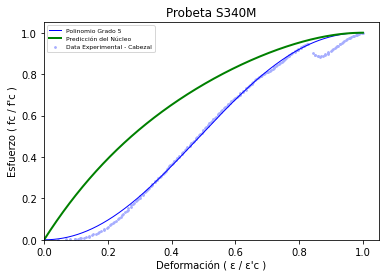

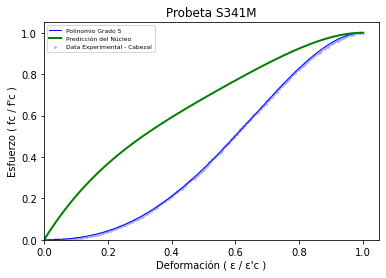

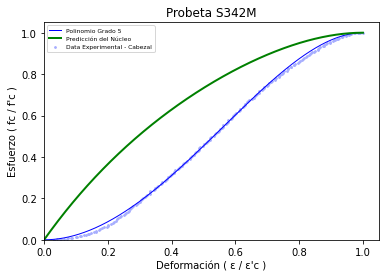

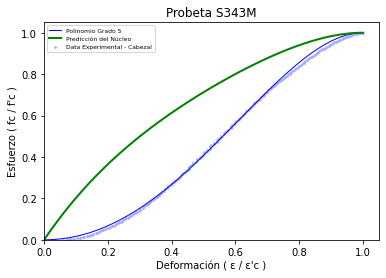

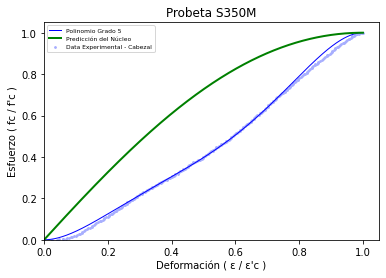

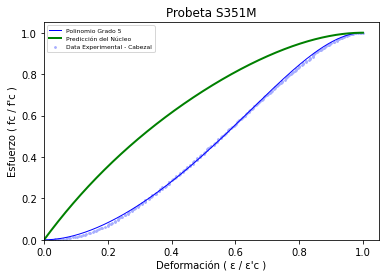

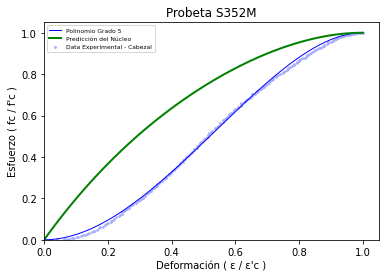

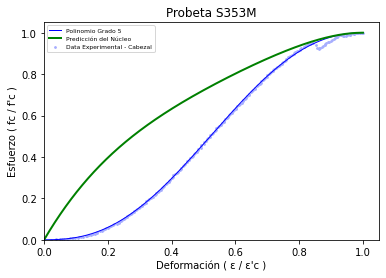

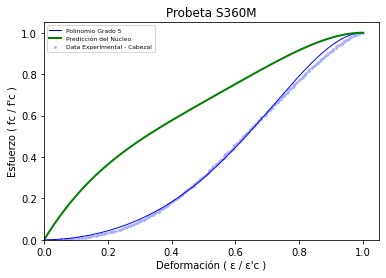

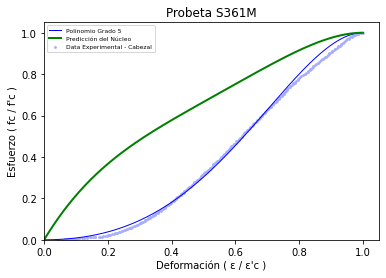

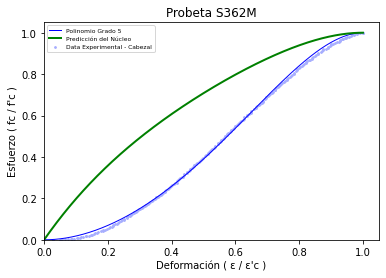

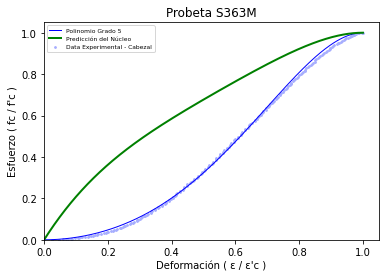

In [ ]:
for h in range(len(filenames)):
  df = pd.read_table(RutaDeEntrada+filenames[h], sep = '\t', names = ['step', 'date', 'ch0', 'ch1', 'ch2', 'cabezal'], skiprows = 1, header = None, encoding = 'latin')

  loads = df[['ch0']].to_numpy()
  f = lambda x: (x-df.loc[0,'ch0'])
  loads = f(loads)

  fuerzas = loads.copy()

  dis_ch1 = df[['ch1']].to_numpy()
  dis_ch2 = df[['ch2']].to_numpy()

  dis_cabezal = []
  for i in range(len(loads)):
    dis_cabezal.insert(i,(dis_ch1[i]+dis_ch2[i])/2)

  desplazamientos = dis_cabezal.copy()

  mayor_load = loads[0]
  for i in range(len(loads)):
    if loads[i] > mayor_load:
      mayor_load = loads[i]
      posicion = i

  

  f = lambda x: x/mayor_load
  stress = f(loads)

  g = lambda x: x/dis_cabezal[posicion]
  strain_c = g(dis_cabezal)

  index = tuple(n for n in range(posicion + 1, len(stress)))
  stress = np.delete(stress, index)
  strain_c = np.delete(strain_c, index)

  #PROCESAMIENTO DEL CABEZAL - POL DE GRADO 5#
  lista_a11 = []
  lista_a12 = []
  lista_a22 = []
  lista_b1 = []
  lista_b2 = []

  for i in range(len(stress)):
    lista_a11.insert(i,(-0.5*strain_c[i]**2+2*strain_c[i]**3-2.5*strain_c[i]**4+strain_c[i]**5)**2)
    lista_a12.insert(i,(-0.5*strain_c[i]**2+2*strain_c[i]**3-2.5*strain_c[i]**4+strain_c[i]**5)*(30*strain_c[i]**2-60*strain_c[i]**3+30*strain_c[i]**4))
    lista_a22.insert(i,(30*strain_c[i]**2-60*strain_c[i]**3+30*strain_c[i]**4)**2)
    lista_b1.insert(i,(-0.5*strain_c[i]**2+2*strain_c[i]**3-2.5*strain_c[i]**4+strain_c[i]**5)*(stress[i]+12*strain_c[i]**2-28*strain_c[i]**3+15*strain_c[i]**4))
    lista_b2.insert(i,(30*strain_c[i]**2-60*strain_c[i]**3+30*strain_c[i]**4)*(stress[i]+12*strain_c[i]**2-28*strain_c[i]**3+15*strain_c[i]**4))

  a11 = sum(lista_a11)
  a12 = sum(lista_a12)
  a21 = a12
  a22 = sum(lista_a22)
  b1 = sum(lista_b1)
  b2 = sum(lista_b2)

  A = np.matrix([[a11,a12],[a21,a22]])
  b = np.matrix([[b1],[b2]])

  parametros = np.linalg.solve(A,b)

  c5 = float(parametros[0])
  uc = float(parametros[1])

  c0 = 0
  c1 = 0
  c2 = -12+30*uc-0.5*c5
  c3 = 28-60*uc+2*c5
  c4 = -15+30*uc-2.5*c5
  c5 = c5
  x40 = PolGra5(c0, c1, c2, c3, c4, c5, 0.55, 10**(-6), 0.4)
  x60 = PolGra5(c0, c1, c2, c3, c4, c5, 0.7, 10**(-6), 0.6)
  m4060 = 0.2/(PolGra5(c0, c1, c2, c3, c4, c5, 0.7, 10**(-6), 0.6)-PolGra5(c0, c1, c2, c3, c4, c5, 0.55, 10**(-6), 0.4))

  xcc = np.linspace(0, 1, 1000)

  i = 0
  stress_cab = []
  for i in range(len(xcc)):
    stress_cab.insert(i,c0+c1*xcc[i]+c2*xcc[i]**2+c3*xcc[i]**3+c4*xcc[i]**4+c5*xcc[i]**5)

  ###CALCULO DEL NUCLEO###
  r = 0.6547808450*np.exp(0.8031398647*m4060)
  un = 0.5031812260*np.exp(0.5720259702*uc)

  n0 = 0
  n1 = r
  n2 = -12+30*un-4.5*r
  n3 = 28-60*un+6*r
  n4 = -15+30*un-2.5*r

  xnn = np.linspace(0, 1, 1000)

  i = 0
  stress_nuc_metodo = []
  for i in range(len(xnn)):
    stress_nuc_metodo.insert(i,n0+n1*xnn[i]+n2*xnn[i]**2+n3*xnn[i]**3+n4*xnn[i]**4)

  ###GRÁFICA NUCLEO / CABEZAL######COMENTAR SI DESEA OBTENER EXCEL !!!DESCOMENTAR SI DESEA OBTENER GRAFICAS###
  xc = strain_c
  y = stress
  yc = stress_cab
  ynn = stress_nuc_metodo
  fig, ax = plt.subplots()
  ax.set_title("Probeta "+fnames[h])
  plt.axis([0, 1.05, 0, 1.05])
  ax.scatter(xc,y, s=3, c="#A7AEFE", label="Data Experimental - Cabezal")
  ax.plot(xcc,yc, "b", lw=1, linestyle = "-", label="Polinomio Grado 5")
  ax.plot(xnn,ynn, "g", lw=2, linestyle = "-", label="Predicción del Núcleo" )
  plt.xlabel("Deformación ( ɛ / ɛ'c )")
  plt.ylabel("Esfuerzo ( fc / f'c )")
  ax.legend(fontsize=6, loc='upper left')
  plt.savefig(RutaDeSalida+'Figura{0}.jpg'.format(h+1), dpi=2400)






  #!!!COMENTAR SI DESEA OBTENER GRAFICAS !!!DESCOMENTAR SI DESEA OBTENER EXCEL
  # datos.iloc[h] = [filenames[h], uc, un, m4060, r, x40, x60]
#datos.to_excel('Parametros_Sin_Nucleo.xlsx', index = False)

In [ ]:
# #CALCULO DEÑ NUCLEO#
# r = m4060*fm
# un = uc*fu

# n0 = 0
# n1 = r
# n2 = -12+30*un-4.5*r
# n3 = 28-60*un+6*r
# n4 = -15+30*un-2.5*r

# i = 0
# stress_nucleo = []
# for i in range(len(stress)):
#   stress_nucleo.insert(i,n0+n1*strain_n[i]+n2*strain_n[i]**2+n3*strain_n[i]**3+n4*strain_n[i]**4)

In [ ]:
# #GRÁFICA NUCLEO / CABEZAL / METODO#
# xn = strain_n
# xc = strain_c
# y = stress
# yn = stress_nuc
# yc = stress_cab
# xn_met = strain_n
# yn_met = stress_nucleo
# fig, ax = plt.subplots()
# plt.axis([0, 1.1, 0, 1.1])
# ax.scatter(xn,y, s=3)
# ax.scatter(xc,y, s=3)
# ax.plot(xnn,yn, "r", lw=1, linestyle = "-", label="Polinomio Grado 4" )
# ax.plot(xcc,yc, "b", lw=1, linestyle = "-", label="Polinomio Grado 5" )
# ax.plot(xn_met,yn_met,"g", lw=1, linestyle = "-", label="Método")
# # ax.plot(xc,yc,'b', lw=2, linestyle = "-", label="Polinomio Grado 5")
# ax.legend(loc = 'upper left')
# plt.show()